# I-Front Test

We first consider the simplest example, HII region expansion around a single source of ionizing radiation and  constant density field. 

This test is known as the ionization front (_I-front_) test and is a standard test in reionization [(Mellema+ 2006)](https://arxiv.org/abs/astro-ph/0508416).

In [2]:
import pyc2ray as pc2r
import numpy as np, matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import astropy.units as u

## Analytical Solution

Here, we consider a source emitting $\dot{N}_\gamma$ ionizing photons per unit of time igniting in a medium of neutral hydrogen with number density $n_\mathrm{H}$.

The ionizing photons propagate, resulting in an I-front with a radius, $r_I$, that ionizes the surrounding neutral gas. The I-front propagation speed, $v_I$, is determined by the balance between the flux of ionizing photons and the number of neutral atoms.

$$ n_\mathrm{H} \frac{dV_I}{dt} = \dot{N}_\gamma - \int_{V_I} n^2_\mathrm{H}\,C\alpha_B\,dV$$

where $V_I = \frac{4\pi}{3}r^3_I$, and in this case, an analytical solution exist.

In [3]:
# Analytical Solution
Ngamma = 1e54 / u.s
nH = 1.87e-4 / u.cm**3
alpha_B = 2.59e-13 * u.cm**3 / u.s
clump = 5

r_S = ((3*Ngamma/(4*np.pi*clump*alpha_B*nH**2))**(1./3)).to('kpc')
t_rec = (1.0 / (clump*alpha_B*nH)).to('Myr')

print("r_S = ", r_S)
print("t_rec = ", t_rec)

def r_I(t):
    return r_S * (1.0 - np.exp(-t/t_rec))**(1./3)

def v_I(t):
    return (r_S/(3*t_rec) * (np.exp(-t/t_rec))/(1.0 - np.exp(-t/t_rec))**(2./3)).to('km/s')

r_S =  564.0300697516011 kpc
t_rec =  130.85329347357774 Myr


Calculate analytical solution and plot results.

In [4]:
t_evol = 5e8 # years

t_analytical = np.linspace(0, t_evol*u.yr, 200, endpoint=True).to('Myr')

r_analytical = r_I(t_analytical)
v_analytical = v_I(t_analytical[1:])

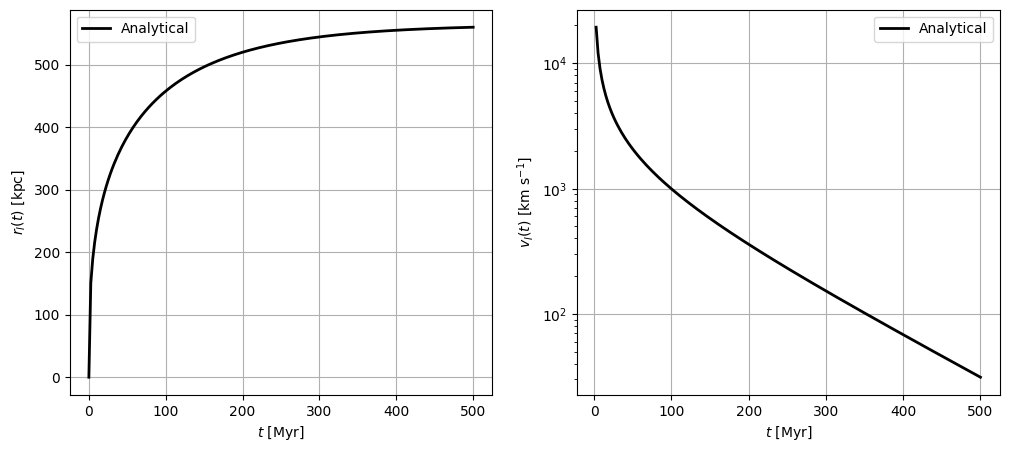

In [5]:
fig, axs = plt.subplots(figsize=(12,5), ncols=2, nrows=1)

axs[0].plot(t_analytical, r_analytical, color='black', ls='-', label="Analytical", lw=2)
axs[0].set_ylabel("$r_I(t)$ [kpc]")

axs[1].semilogy(t_analytical[1:],v_analytical,color='black',label="Analytical",lw=2)
axs[1].set_ylabel("$v_I(t)$ [km s$^{-1}$]")

for ax in axs:
    ax.set_xlabel("$t$ [Myr]")
    ax.grid()
    ax.legend()

## Numerical Solution

Here, we use pyC$^2$Ray to compute the I-front and test whether it provides the correct solution.

The coarseness of the numerical solution depends on the number of time steps. Here, we define the number of redshift steps we want to output. Increasing the value of `numzred` will refine the numerical solution and increase the computing time (`numzred=10` takes approximately __15 minutes__).

In [6]:
numzred = 10

Define some global parameters and instance the test simulation class.

In [7]:
# Global parameters
num_steps_between_slices = 1

# Create C2Ray object
sim = pc2r.C2Ray_Test(paramfile='parameters_ifront.yml')

                 _________   ____            
    ____  __  __/ ____/__ \ / __ \____ ___  __
   / __ \/ / / / /    __/ // /_/ / __ `/ / / /
  / /_/ / /_/ / /___ / __// _, _/ /_/ / /_/ / 
 / .___/\__, /\____//____/_/ |_|\__,_/\__, /  
/_/    /____/                        /____/   

Welcome! Mesh size is N = 256.
Simulation Box size (comoving Mpc): 1.620e+00
Cosmology is off.
Using Black-Body sources with effective temperature T = 5.0e+04 K and Radius  1.437e-11 rsun
Spectrum Frequency Range: 3.288e+15 to 1.316e+17 Hz
This is Energy:           1.360e+01 to 5.442e+02 eV
Integrating photoionization rates tables...
INFO: No heating rates

---- Calculated Clumping Factor (constant model):
 min, mean and max clumping : 5.000e+00  5.000e+00  5.000e+00

---- Calculated Mean-Free Path (constant model):
Maximum comoving distance for photons from source mfp = 15.00 cMpc (constant model).
 This corresponds to 2370.048 grid cells.

Using CPU Raytracing (subboxsize = 128, max_subbox = 1000)
Running i

Read the source file and define some redshift step.

In [8]:
# Generate redshift list (test case)
t_evol = 5e8 # years
zred_array = sim.generate_redshift_array(numzred+1,t_evol/numzred)

# Read sources
numsrc = 1
srcpos, srcflux = sim.read_sources("src_ifront.txt", numsrc)

In [9]:
# Start the timer ot measure the wall clock time
timer = pc2r.Timer()
timer.start()

# Loop over redshifts
for k in range(len(zred_array)-1):
    # Compute timestep of current redshift slice
    zi = zred_array[k]
    zf = zred_array[k+1]

    sim.printlog("\n==============\nDoing redshift %.3f to %.3f\n==============\n" %(zi, zf), sim.logfile)

    # Compute timestep of current redshift slice
    dt = sim.set_timestep(zi,zf,num_steps_between_slices)
    
    # Write output
    sim.write_output(zi)
    
    # Set density (when cosmological is false, zi has no effect)
    sim.density_init(zi)
    
    # Set redshift to current slice redshift
    sim.zred = zi
 
    # Do num_steps_between_slices timesteps
    for t in range(num_steps_between_slices):
        sim.printlog("\n --- Timestep %d. Redshift: z = %.3f --- \n" %(t+1, sim.zred), sim.logfile)

        # Evolve Cosmology: increment redshift and scale physical quantities (density, proper cell size, etc.). If cosmology is disabled in parameter, this step does nothing (checked internally by the class)
        sim.cosmo_evolve(dt)

        # Evolve the simulation: raytrace -> photoionization rates -> chemistry -> until convergence
        sim.evolve3D(dt, srcflux, srcpos)
        
        # Register elapsed Wall clock time
        tnow = timer.lap('k=%d, t=%d' %(k,t))
            
# stop the timer and print the summary
timer.stop()
sim.printlog(timer.summary, sim.logfile)

Calling evolve3D...
dr [Mpc]: 6.328e-03
dt [years]: 5.000e+07
Running on 1 source(s), total normalized ionizing flux: 1.00e+06
Mean density (cgs): 1.870e-04, Mean ionized fraction: 1.200e-03
Convergence Criterion (Number of points):  0

Rank=0 is doing Raytracing... took 1.36s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 19 of 16777216 ( 0.000 % ), Relative change in ionfrac:  1.67e+03
Rank=0 is doing Raytracing... took 1.38s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 32 of 16777216 ( 0.000 % ), Relative change in ionfrac:  1.12e-03
Rank=0 is doing Raytracing... took 1.38s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 98 of 16777216 ( 0.001 % ), Relative change in ionfrac:  4.83e-03
Rank=0 is doing Raytracing... took 1.38s.
Average number of subboxe

Rank=0 is doing Raytracing... took 1.41s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 49828 of 16777216 ( 0.297 % ), Relative change in ionfrac:  6.04e-02
Rank=0 is doing Raytracing... took 1.40s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 52456 of 16777216 ( 0.313 % ), Relative change in ionfrac:  5.79e-02
Rank=0 is doing Raytracing... took 1.40s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 54868 of 16777216 ( 0.327 % ), Relative change in ionfrac:  5.53e-02
Rank=0 is doing Raytracing... took 1.41s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 56530 of 16777216 ( 0.337 % ), Relative change in ionfrac:  5.34e-02
Rank=0 is doing Raytracing... took 1.41s.
Average number of 

Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 85264 of 16777216 ( 0.508 % ), Relative change in ionfrac:  6.72e-03
Rank=0 is doing Raytracing... took 1.43s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 83608 of 16777216 ( 0.498 % ), Relative change in ionfrac:  5.69e-03
Rank=0 is doing Raytracing... took 1.41s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 81800 of 16777216 ( 0.488 % ), Relative change in ionfrac:  4.69e-03
Rank=0 is doing Raytracing... took 1.42s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 78824 of 16777216 ( 0.470 % ), Relative change in ionfrac:  4.03e-03
Rank=0 is doing Raytracing... took 1.41s.
Average number of subboxes: 1, Total photon loss: 0.000e+00


Doing Chemistry... took  0.9 s.
Number of non-converged points: 141164 of 16777216 ( 0.841 % ), Relative change in ionfrac:  1.53e-02
Rank=0 is doing Raytracing... took 1.41s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 141596 of 16777216 ( 0.844 % ), Relative change in ionfrac:  1.39e-02
Rank=0 is doing Raytracing... took 1.47s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.2 s.
Number of non-converged points: 140824 of 16777216 ( 0.839 % ), Relative change in ionfrac:  1.25e-02
Rank=0 is doing Raytracing... took 1.41s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 140052 of 16777216 ( 0.835 % ), Relative change in ionfrac:  1.13e-02
Rank=0 is doing Raytracing... took 1.41s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged 

Rank=0 is doing Raytracing... took 1.42s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 168820 of 16777216 ( 1.006 % ), Relative change in ionfrac:  1.03e-02
Rank=0 is doing Raytracing... took 1.42s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 167440 of 16777216 ( 0.998 % ), Relative change in ionfrac:  9.09e-03
Rank=0 is doing Raytracing... took 1.42s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 164380 of 16777216 ( 0.980 % ), Relative change in ionfrac:  7.89e-03
Rank=0 is doing Raytracing... took 1.42s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  0.9 s.
Number of non-converged points: 162028 of 16777216 ( 0.966 % ), Relative change in ionfrac:  6.74e-03
Rank=0 is doing Raytracing... took 1.42s.
Average number

Doing Chemistry... took  1.0 s.
Number of non-converged points: 164204 of 16777216 ( 0.979 % ), Relative change in ionfrac:  2.98e-03
Rank=0 is doing Raytracing... took 1.42s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 158966 of 16777216 ( 0.948 % ), Relative change in ionfrac:  2.30e-03
Rank=0 is doing Raytracing... took 1.43s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 153566 of 16777216 ( 0.915 % ), Relative change in ionfrac:  1.74e-03
Rank=0 is doing Raytracing... took 1.42s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 148226 of 16777216 ( 0.883 % ), Relative change in ionfrac:  1.30e-03
Rank=0 is doing Raytracing... took 1.42s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged 

Rank=0 is doing Raytracing... took 1.42s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 75920 of 16777216 ( 0.453 % ), Relative change in ionfrac:  8.46e-05
Multiple source convergence reached after 22 ray-tracing iterations.
Calling evolve3D...
dr [Mpc]: 6.328e-03
dt [years]: 5.000e+07
Running on 1 source(s), total normalized ionizing flux: 1.00e+06
Mean density (cgs): 1.870e-04, Mean ionized fraction: 1.442e-01
Convergence Criterion (Number of points):  0

Rank=0 is doing Raytracing... took 1.41s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 279586 of 16777216 ( 1.666 % ), Relative change in ionfrac:  1.26e+01
Rank=0 is doing Raytracing... took 1.43s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 203256 of 16777216 ( 1.212 % ), Relative change in ionfra

Doing Chemistry... took  1.0 s.
Number of non-converged points: 139062 of 16777216 ( 0.829 % ), Relative change in ionfrac:  2.16e-04
Rank=0 is doing Raytracing... took 1.42s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 126174 of 16777216 ( 0.752 % ), Relative change in ionfrac:  1.59e-04
Rank=0 is doing Raytracing... took 1.43s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 108718 of 16777216 ( 0.648 % ), Relative change in ionfrac:  1.18e-04
Rank=0 is doing Raytracing... took 1.42s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 86534 of 16777216 ( 0.516 % ), Relative change in ionfrac:  8.78e-05
Multiple source convergence reached after 16 ray-tracing iterations.
Calling evolve3D...
dr [Mpc]: 6.328e-03
dt [years]: 5.000e+07
Running on 1 source(s), tota

Doing Chemistry... took  1.0 s.
Number of non-converged points: 152100 of 16777216 ( 0.907 % ), Relative change in ionfrac:  3.10e-04
Rank=0 is doing Raytracing... took 1.44s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 125576 of 16777216 ( 0.748 % ), Relative change in ionfrac:  1.77e-04
Rank=0 is doing Raytracing... took 1.43s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 83592 of 16777216 ( 0.498 % ), Relative change in ionfrac:  1.03e-04
Rank=0 is doing Raytracing... took 1.43s.
Average number of subboxes: 1, Total photon loss: 0.000e+00
Doing Chemistry... took  1.0 s.
Number of non-converged points: 53114 of 16777216 ( 0.317 % ), Relative change in ionfrac:  6.12e-05
Multiple source convergence reached after 9 ray-tracing iterations.


Let's have a look the wall clock time for this run.

In [10]:
print(timer.summary)


--- TIMER SUMMARY ---
 step 1: 3m 23.98s - k=0, t=0
 step 2: 1m 33.71s - k=1, t=0
 step 3: 1m 14.54s - k=2, t=0
 step 4: 1m 3.18s - k=3, t=0
 step 5: 53.77s - k=4, t=0
 step 6: 46.38s - k=5, t=0
 step 7: 39.24s - k=6, t=0
 step 8: 29.46s - k=7, t=0
 step 9: 24.79s - k=8, t=0
 step 10: 22.35s - k=9, t=0
Elapsed time: 10m 51.39s 


Here, we calculate the numerical solution for $r_I$. We define the I-front position as the point where the gas is 50% ionized. Here, we use a simple interpolation for a line of sight starting at the center of the box.

The I-front velocity, $v_I$, was obtained by simple finite-differencing of its position based on the current and previous time steps.

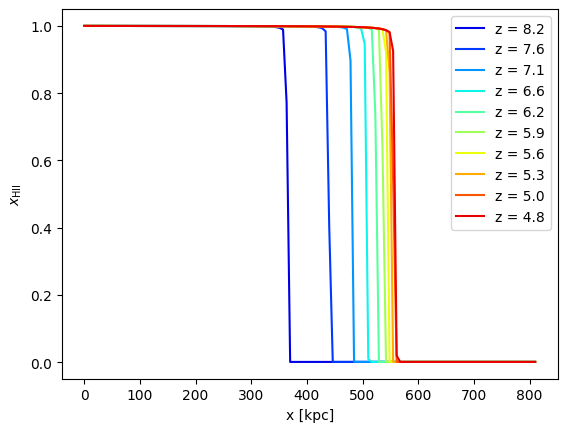

(None, None)

<Figure size 640x480 with 0 Axes>

In [11]:
# get half box length for interpolation in kpc
xc = np.linspace(0, sim.boxsize*1000/2, sim.N//2)

# get time of the corresponding redshift step
t_num = (sim.cosmology.age(zred_array) - sim.cosmology.age(sim.zred_0)).to('Myr')
t_aveg = 0.5*(t_num[1:]+t_num[:-1])

# get numerical radius and velocity
r_num = np.zeros_like(zred_array)
v_num = np.zeros(zred_array.size-1)

for k, z in enumerate(zred_array):
    # load ionized fraction
    xh = np.load('%sxfrac_%.3f.npy' %(sim.results_basename, z))
    
    # line of sight from the center to the box side
    los_xh = xh[sim.N//2:,sim.N//2,sim.N//2]
    
    # Compute the I-front radius at 50% ionized
    r_num[k] = np.interp(0.5, np.flip(los_xh), np.flip(xc)) 
    
    # Compute the I-front velocity
    if(k > 0):
        v_num[k-1] = ((r_num[k] - r_num[k-1])/(t_num[k]-t_num[k-1]) * u.kpc).to('km/s').value
        
        # plt the xHII profile
        plt.plot(xc, los_xh, label='z = %.1f' %z, color=plt.cm.jet(k/zred_array.size))
        plt.legend()
        
plt.xlabel('x [kpc]'), plt.ylabel(r'$x_\mathrm{HII}$')
plt.show(), plt.clf()

We plot the final result and compare the numerical and the analytical solutions. Despite employing only a few redshift steps (`numzred = 10`), the numerical solution agrees well with the analytical solution.

Increasing the value of `numzred`, for instance to 100, will have a less coarse numerical solution however, it will increase the computing time substantially.

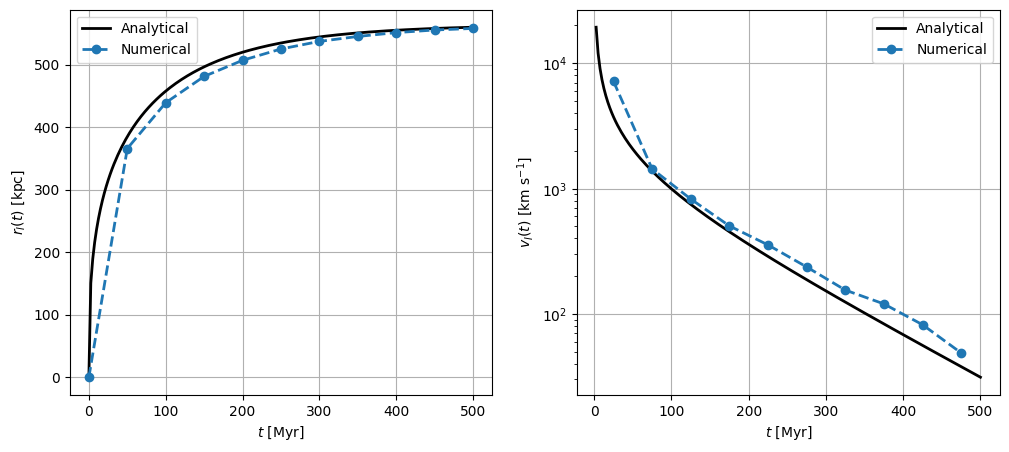

In [12]:
fig, axs = plt.subplots(figsize=(12,5), ncols=2, nrows=1)

axs[0].plot(t_analytical, r_analytical, color='black', ls='-', label="Analytical", lw=2)
axs[0].plot(t_num, r_num, color='tab:blue', marker='o', ls='--', label="Numerical", lw=2)
axs[0].set_ylabel("$r_I(t)$ [kpc]")

axs[1].semilogy(t_analytical[1:],v_analytical,color='black',label="Analytical",lw=2)
axs[1].plot(t_aveg, v_num, color='tab:blue', marker='o', ls='--', label="Numerical", lw=2)
axs[1].set_ylabel("$v_I(t)$ [km s$^{-1}$]")

for ax in axs:
    ax.set_xlabel("$t$ [Myr]")
    ax.grid()
    ax.legend()